<a href="https://colab.research.google.com/github/filippozuddas/ML-SRT-SETI/blob/main/notebooks/train_CVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install setigen

In [1]:
import sys
import os

# --- CONFIGURAZIONE PERCORSI ---
PROJECT_ROOT = "/content/filippo/ML-SRT-SETI"
PROJECT_ROOT_LOCAL = "/home/filippo/TirocinioSETI/ML-SRT-SETI"

if not os.path.exists(PROJECT_ROOT):
    raise FileNotFoundError(f"{PROJECT_ROOT} folder not found")

os.chdir(PROJECT_ROOT)

if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

print(f"✅ Setup completed!")
print(f"   Working directory: {os.getcwd()}")

✅ Setup completed!
   Working directory: /content/filippo/ML-SRT-SETI


In [2]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from src import config, models
from src.models import VAE

# Verifica GPU
print(f"TensorFlow Version: {tf.__version__}")
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

TensorFlow Version: 2.18.0
Num GPUs Available:  2


In [3]:
DATASET_PATH = "data/synthetic_dataset.npz"
MODELS_FOLDER = "models"
MODELS_WEIGHTS_PATH = "models/weights/beta_vae_weights.h5"

os.makedirs(MODELS_FOLDER, exist_ok=True)

INPUT_SHAPE = (16, 512, 1)
LATENT_DIM = 8
ALPHA = 10.0
BETA = 1.5
BATCH_SIZE = 128
LR = 0.001
EPOCHS = 50

In [4]:
def create_tf_dataset(recon_data, true_data, false_data, batch_size):
    """
    Crea un tf.data.Dataset ottimizzato a partire dai tensori numpy
    """
    # Creazione del dataset da slice di tensori
    # Input X: (Reconstruction, True Cadence, False Cadence)
    # Target Y: Reconstruction
    ds = tf.data.Dataset.from_tensor_slices(
        ((recon_data, true_data, false_data), recon_data)
    )

    # Shuffle, Batching e Prefetching
    # drop_remainder=True è importante per training multi-GPU (MirroredStrategy)
    ds = ds.shuffle(2048).batch(batch_size, drop_remainder=True)
    ds = ds.prefetch(tf.data.AUTOTUNE)

    return ds

def load_data(filepath, split=0.8):
    """
    Carica i dati dal file .npz, esegue lo split e restituisce i dataset TF pronti.
    """
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"File {filepath} non trovato!")

    print(f"Loading data from {filepath}...")
    with np.load(filepath) as f:
        mixed = f['mixed_cadence']
        true_c = f['true_cadence']
        false_c = f['false_cadence']

    print(f"Total samples: {len(mixed)}")

    # Prepariamo l'input per la ricostruzione (Solo il primo frame ON della sequenza)
    # Assumiamo che mixed sia (N, 6, 16, 512, 1) -> x_recon diventa (N, 16, 512, 1)
    x_recon = mixed[:, 0, :, :, :]

    # Creazione degli indici per lo split
    indices = np.arange(len(mixed))
    train_idx, val_idx = train_test_split(indices, train_size=split, random_state=42)

    # Creazione Train Dataset
    # Passiamo direttamente le slice degli array usando gli indici di train
    train_ds = create_tf_dataset(
        recon_data=x_recon[train_idx],
        true_data=true_c[train_idx],
        false_data=false_c[train_idx],
        batch_size=BATCH_SIZE
    )

    # Creazione Validation Dataset
    # Passiamo direttamente le slice degli array usando gli indici di val
    val_ds = create_tf_dataset(
        recon_data=x_recon[val_idx],
        true_data=true_c[val_idx],
        false_data=false_c[val_idx],
        batch_size=BATCH_SIZE
    )

    return train_ds, val_ds

In [5]:
train_dataset, val_dataset = load_data(DATASET_PATH)

Loading data from data/synthetic_dataset.npz...
Total samples: 3200


In [6]:
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    encoder = models.build_encoder(latent_dim=LATENT_DIM)
    decoder = models.build_decoder(latent_dim=LATENT_DIM)
    vae = VAE(encoder, decoder, alpha=ALPHA, beta=BETA)

    # Compilazione con ottimizzatore standard
    vae.compile(optimizer=keras.optimizers.Adam(learning_rate=LR))


In [26]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=5,
        verbose=1
    ),
]

In [ ]:
print("Starting training...")

history = vae.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=callbacks
)

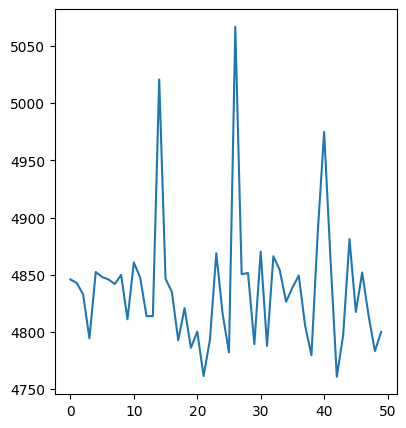

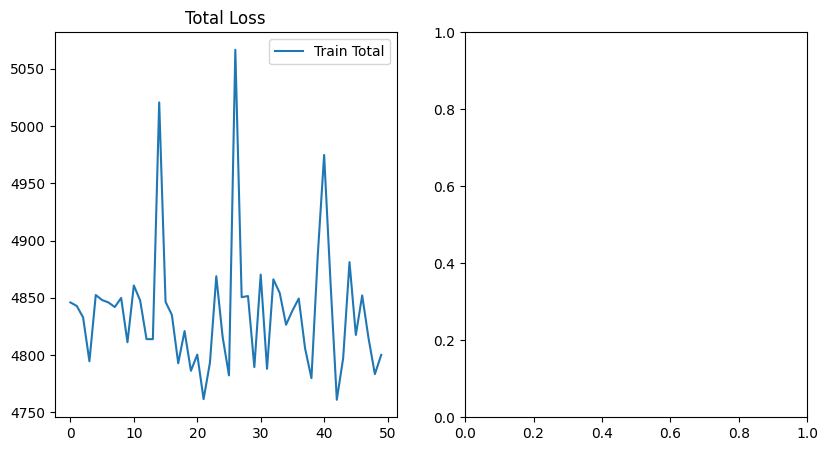

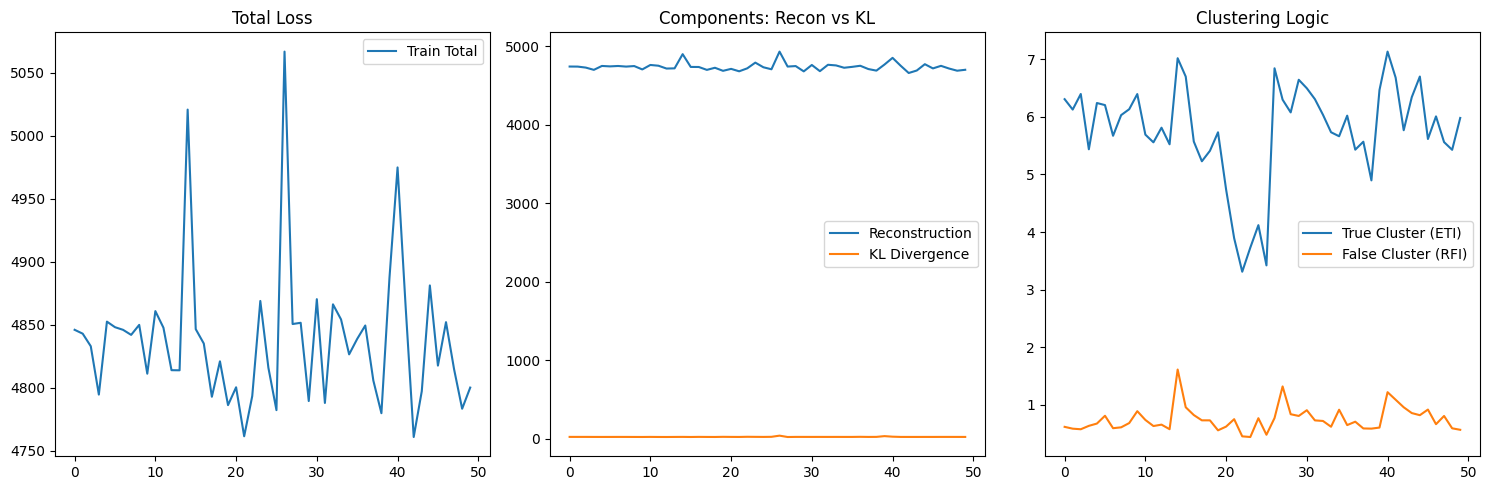

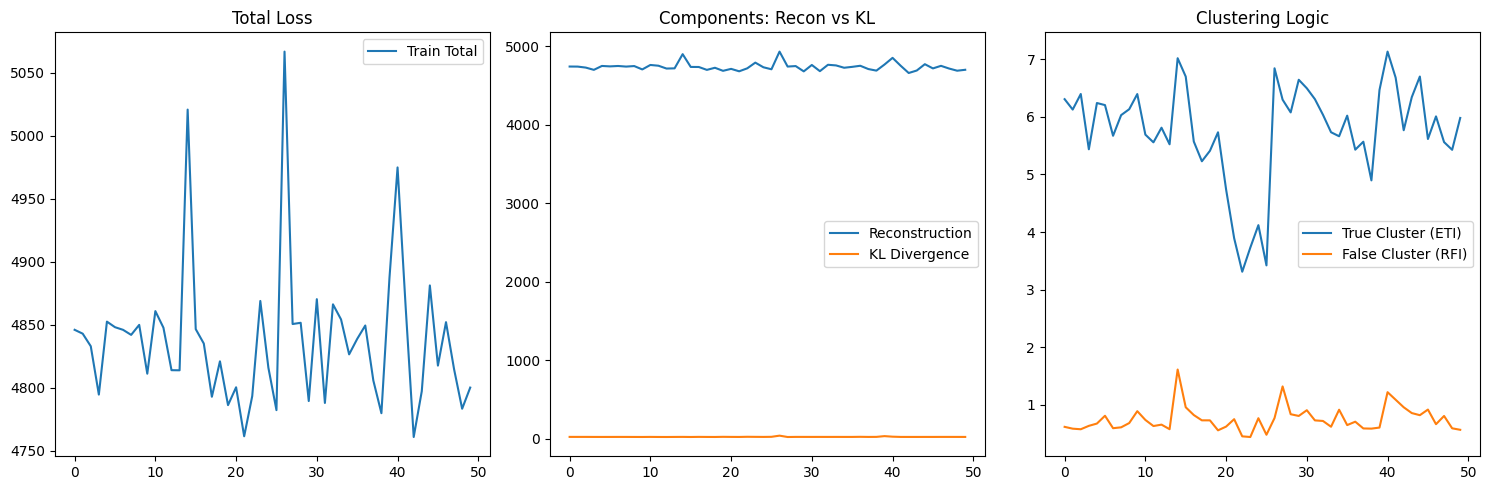

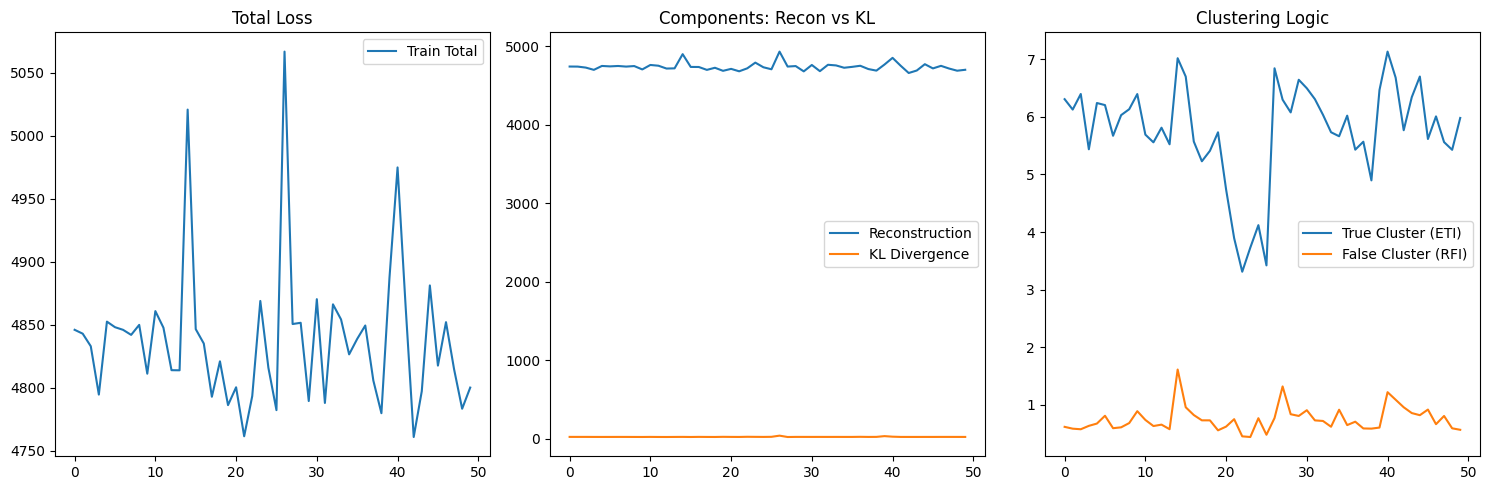

In [21]:
def plot_training_history(hist):
    plt.figure(figsize=(15, 5))

    # 1. Total Loss
    plt.subplot(1, 3, 1)
    plt.plot(hist.history['loss'], label='Train Total')
    if 'val_total_loss' in hist.history:
        plt.plot(hist.history['val_total_loss'], label='Val Total')


    plt.title('Total Loss')
    plt.legend()

    # 2. Recon vs KL
    plt.subplot(1, 3, 2)
    plt.plot(hist.history['reconstruction_loss'], label='Reconstruction')
    plt.plot(hist.history['kl_loss'], label='KL Divergence')
    plt.title('Components: Recon vs KL')
    plt.legend()

    # 3. Clustering
    plt.subplot(1, 3, 3)
    plt.plot(hist.history['true_loss'], label='True Cluster (ETI)')
    plt.plot(hist.history['false_loss'], label='False Cluster (RFI)')
    plt.title('Clustering Logic')
    plt.legend()

    plt.tight_layout()
    plt.show()

%matplotlib inline
plot_training_history(history)

Visualizzazione risultati sul Validation Set:


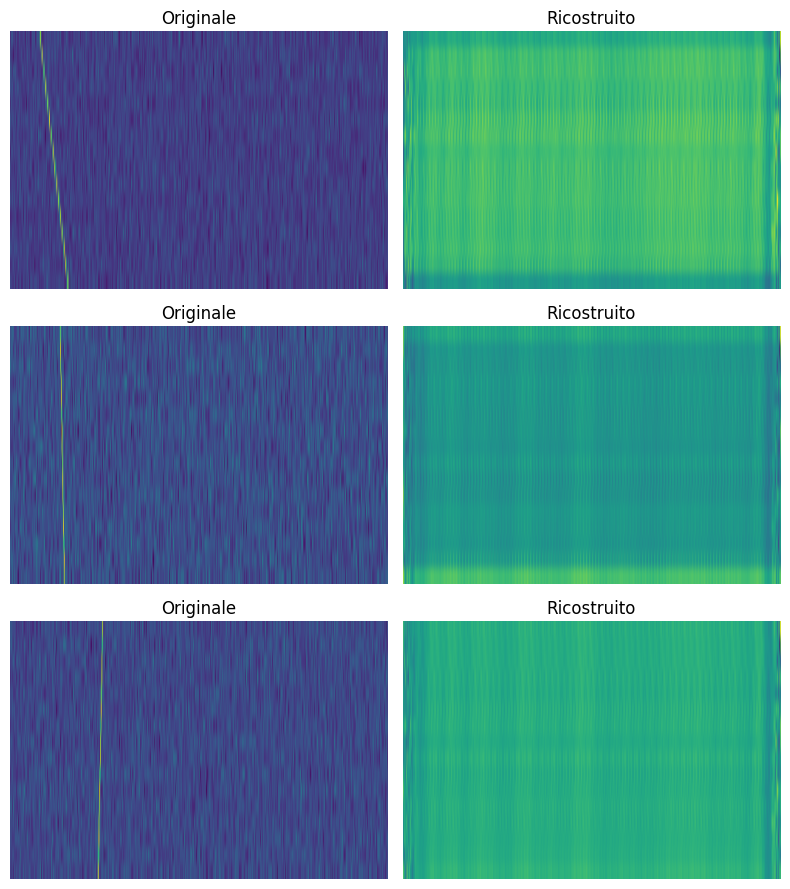

In [23]:
def visualize_reconstruction(dataset, n=3):
    """Visualizza n campioni originali vs ricostruiti"""
    # Prendi un batch dal dataset
    for x, y in dataset.take(1):
        original = x[0][:n] # Prendi i primi n dal batch
        break

    # Predizione (Encoder -> Decoder)
    # predict() gestisce automaticamente la distribuzione su GPU
    z_mean, _, _ = vae.encoder.predict(original, verbose=0)
    reconstructed = vae.decoder.predict(z_mean, verbose=0)

    fig, axes = plt.subplots(n, 2, figsize=(8, 3*n))
    for i in range(n):
        # Originale
        ax = axes[i, 0]
        ax.imshow(original[i, :, :, 0], aspect='auto', cmap='viridis')
        ax.set_title("Originale")
        ax.axis('off')

        # Ricostruito
        ax = axes[i, 1]
        ax.imshow(reconstructed[i, :, :, 0], aspect='auto', cmap='viridis')
        ax.set_title("Ricostruito")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

print("Visualizzazione risultati sul Validation Set:")
visualize_reconstruction(val_dataset)